In [1]:
import numpy as np
from adaptive_latents.regressions import VanillaOnlineRegressor
import matplotlib.pyplot as plt

from tqdm import tqdm

from adaptive_latents.transforms import jpca
from adaptive_latents.bw_run import AnimationManager
import adaptive_latents

from scipy.io import loadmat

rng = np.random.default_rng(0)

## Load Data

In [2]:
# obs, raw_behavior, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_buzaki_data(individual_identifier=adaptive_latents.input_sources.datasets.individual_identifiers["buzaki"][0], bin_width=0.015)
# obs = adaptive_latents.input_sources.prosvd_data(input_arr=obs, output_d=6, init_size=50)
# obs = adaptive_latents.input_sources.functional.center_from_first_n(obs)

In [3]:
# obs, raw_behavior, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_indy_data(
#     adaptive_latents.input_sources.datasets.individual_identifiers["indy"][0],
#     bin_width=0.06,
# )
# obs = adaptive_latents.input_sources.prosvd_data(input_arr=obs, output_d=6, init_size=50)
# obs = adaptive_latents.input_sources.functional.center_from_first_n(obs)

In [4]:
# data = loadmat(adaptive_latents.CONFIG["data_path"] / 'church' / 'exampleData.mat', squeeze_me=True, simplify_cells=True)['Data']
# A = []
# times = data[0]['times']
# for d in data:
#     A.append(d['A'])
#     assert np.all(times == d['times'])
# A = np.array(A)


# AA = np.array(A)
# AA[:,-1,:] = np.nan
# obs = AA.reshape((-1, 218))

# # obs -= np.nanmean(obs,axis=0)
# obs = adaptive_latents.input_sources.prosvd_data(input_arr=obs, output_d=6, init_size=50)

## Make a Movie

In [5]:
m, n = 200, 4
X, _, true_variables = jpca.generate_circle_embedded_in_high_d(np.random.default_rng(42),m=m,n=n, shape=(10,10))

In [6]:
class CustomAnimation(AnimationManager):
    n_rows = 2
    n_cols = 1
    fps = 40
    def draw_frame(self, step, history, errors):
        self.ax[0,0].cla()
        self.ax[0,0].plot(history[-100:,0], history[-100:,1])
        self.ax[0,0].set_title(f"step {step}")
        self.ax[0,0].axis("scaled")

        self.ax[1,0].cla()
        self.ax[1,0].plot(np.log(errors))
        self.ax[1,0].set_title("Aligned difference from true ")
        self.ax[1,0].set_ylabel("log frobenius norm of matrix difference")
        self.movie_writer.grab_frame()


In [34]:
class sjPCA:
    def __init__(self, input_d):
        assert input_d % 2 == 0
        self.input_d = input_d
        self.H = jpca.make_H(self.input_d)
        self.reg = VanillaOnlineRegressor(input_d=self.H.shape[1], output_d=1)
        self.last_x = None

        
    def observe(self, x):
        if self.last_x is None:
            self.last_x = x
            return
            
        dx = x - self.last_x
        rows = jpca.make_X_tilde(x[None,:]) @ self.H
        for j in range(self.input_d):
            xx = rows[j]
            y = dx[j]
            self.reg.observe(xx, y)
        
        
        self.last_x = x


sjpca = sjPCA(input_d=n)
for i in tqdm(range(X.shape[0])):
    sjpca.observe(X[i])
    # rows = jpca.make_X_tilde(X[i, None]) @ H
    # for j in range(n):
    #     x = rows[j]
    #     y = X_dot[i, j]
    #     reg.observe(x, y)


100%|███████████████████████████████████████| 199/199 [00:00<00:00, 1043.06it/s]


In [33]:
sjpca.reg.F

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [35]:
sjpca.last_x - X[i]

array([0., 0., 0., 0.])

100%|█████████████████████████████████████████| 199/199 [00:26<00:00,  7.46it/s]


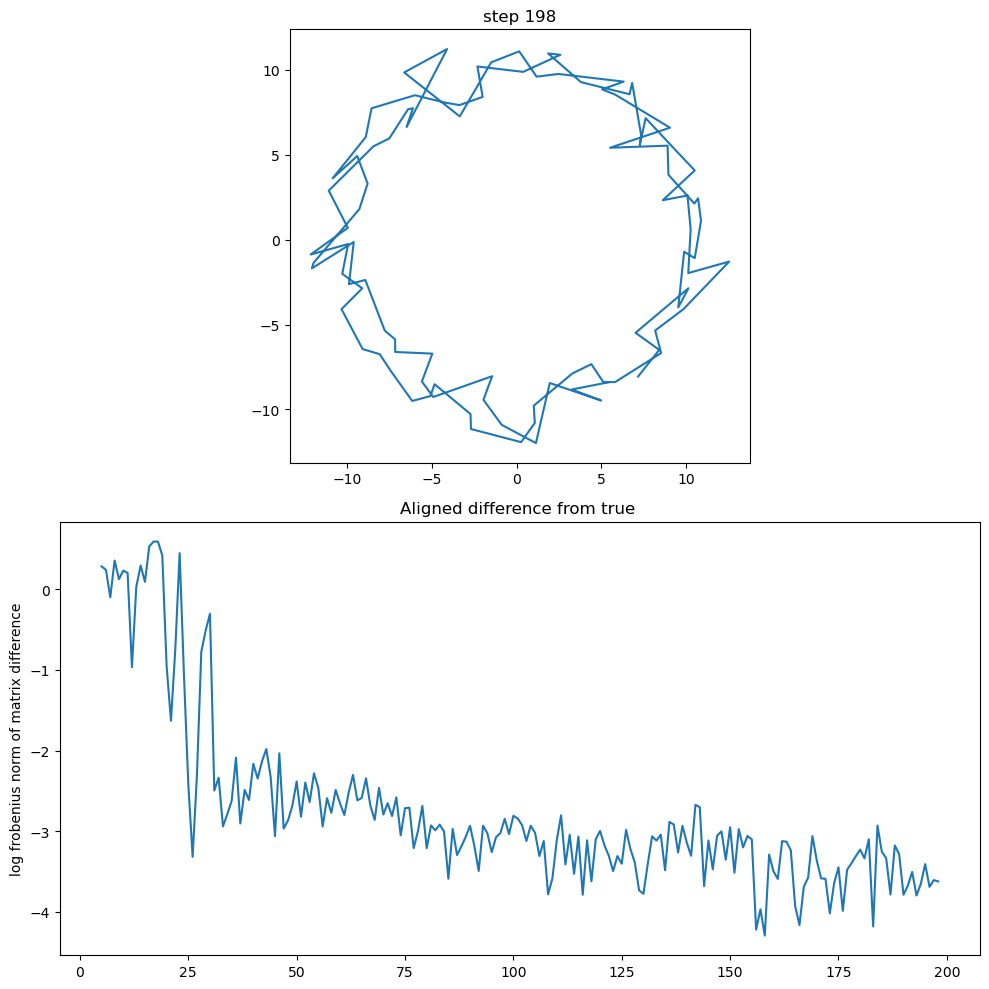

In [36]:
am = CustomAnimation()

observations = []
errors = []
U_history = []
k_history = []
U = None

sjpca = sjPCA(input_d=X.shape[1])
for i in tqdm(range(X.shape[0])):
    sjpca.observe(X[i])
    
    k = sjpca.reg.get_beta()
    U = jpca.U_from_beta(k, X.shape[1], U)
    U_history.append(U)
    k_history.append(k)
    observations.append(X[i] @ U)
    if true_variables is not None:
        try:
            A,B = jpca.align_column_spaces(U[:,:2], true_variables['C'])
            errors.append(np.linalg.norm(A-B))
        except np.linalg.LinAlgError:
            errors.append(np.nan)
    am.draw_frame(i,np.array(observations), errors)


if am is not None: 
    am.set_final_output_location("/home/jgould/Documents/AdaptiveLatents/generated/other/animation.mp4")
    am.finish()

observations = np.array(observations)
U_history = np.array(U_history)
k_history = np.squeeze(k_history)

(1010.0, 1012.0)

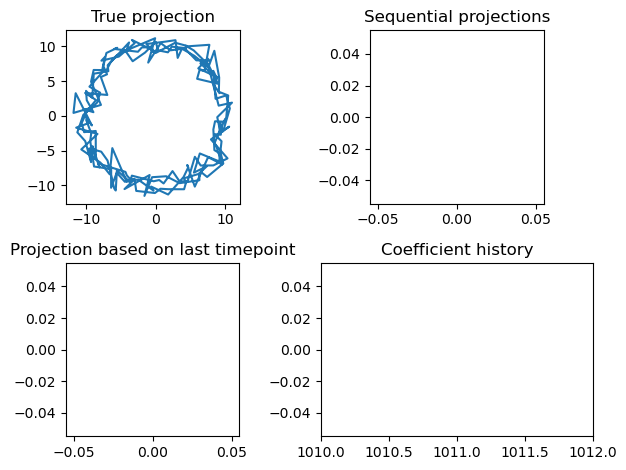

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, layout='tight')

start = -200

result = X @ true_variables['C']
axs[0,0].plot(result[start:,0], result[start:,1])
axs[0,0].set_title("True projection")
axs[0,0].axis('scaled')


result = (U_history.transpose((0,2,1)) @  X[:,:,None])[:,:,0]
assert np.allclose(observations, result, equal_nan=True)
axs[0,1].plot(result[start:,0], result[start:,1])
axs[0,1].set_title("Sequential projections")
axs[0,1].axis('scaled')


result = X @ U_history[-1] 
axs[1,0].plot(result[start:,0], result[start:,1])
axs[1,0].set_title("Projection based on last timepoint")
axs[1,0].axis('scaled')


axs[1,1].plot(U_history[:,1,0], '.')
axs[1,1].set_title("Coefficient history")
axs[1,1].set_xlim([1010,1012])


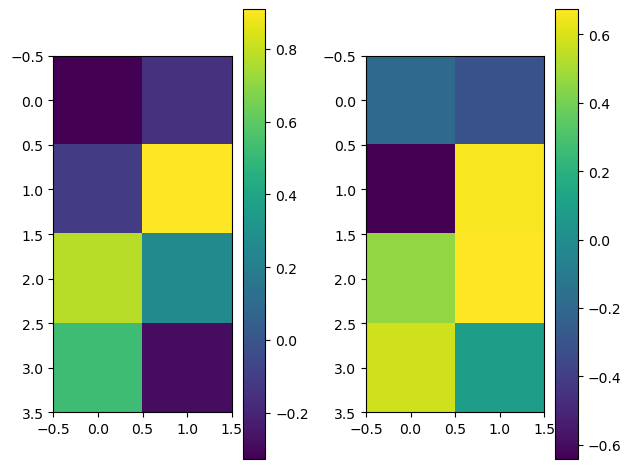

In [10]:
fig, ax = plt.subplots(ncols=2, layout='tight')
im = ax[0].imshow(U_history[-1][:,:2])
fig.colorbar(im)
im = ax[1].imshow(true_variables['C'])
fig.colorbar(im)

In [27]:
u_rotated - C

array([[ 0.00000000e+00, -5.55111512e-17],
       [ 1.11022302e-16, -3.33066907e-16],
       [-2.77555756e-16, -1.11022302e-16],
       [-1.11022302e-16, -4.16333634e-17]])

In [12]:
last_U = U_history[1011]
U = U_history[1012]

In [22]:
i=0
A = U[:, (i * 2): (i * 2 +2)]
B = last_U[:, (i * 2): (i * 2 +2)]
U, _ = jpca.align_column_spaces(A, B)

In [28]:
C = A @ B.T
u, s, vh = np.linalg.svd(C)
R = vh.T @ u.T
A_rotated = R@A


array([[-0.18817376, -0.308107  ],
       [-0.64222759,  0.66398766],
       [ 0.4634306 ,  0.6744899 ],
       [ 0.58083254,  0.09619688]])

In [25]:
A_rotated - B

array([[ 2.73392420e-15,  6.10622664e-16],
       [-3.33066907e-16, -1.10804853e-16],
       [ 1.55431223e-15,  4.44089210e-16],
       [-5.55111512e-16,  2.77555756e-16]])

In [29]:
A[:,0] @ A[:,1]

-5.551115123125783e-17

In [11]:
# if last_U is not None and np.all(~np.isnan(last_U)):
#     U[:, (i * 2): (i * 2 +2)], _ = align_column_spaces(U[:, (i * 2): (i * 2 +2)], last_U[:, (i * 2): (i * 2 +2)])


array([[-0.09681313,  0.35508488,  0.92980748,  0.        ],
       [ 0.92183917,  0.        ,  0.09598346, -0.37549931],
       [ 0.16319417, -0.79793529,  0.32171616,  0.48287229],
       [-0.3379459 , -0.4870462 ,  0.15081094, -0.7910971 ]])

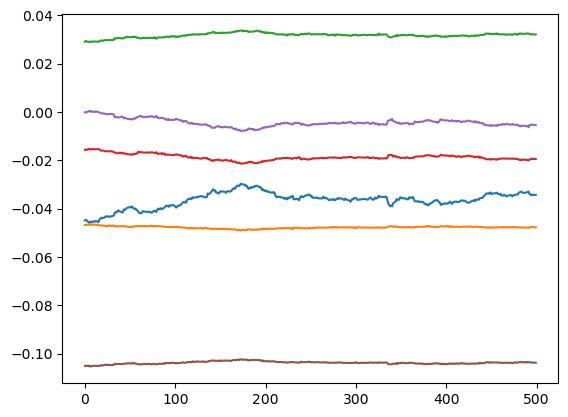

In [32]:
plt.plot(k_history[-500:])